# Predict Which Water Pumps Are Faulty Using Reproducible Code

The project follows CRISP-DM process model to answer business questions. A blog post that communicates the result for this project is available here.

## TOC<a class="anchor" id="toc"></a>

* [Business Understanding](#business_understanding)
* [Data Understanding](#data_understanding)
* [Data Prepocessing](#data_preprocessing)
* [Modeling and Evaluation](#model_eval)
* [Deployment](#deployment)
* [Unit Testing](#unit_test)

## Business Understanding<a class="anchor" id="business_understanding"></a>

[Back to TOC](#toc)

The data set of this project comes from [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) hosted by [DrivenData](https://www.drivendata.org/).

The goal of this project is to predict which pumps are functional, which need some repairs, and which don't work at all by using the data from [Taarifa](http://taarifa.org/) and the [Tanzanian Ministry of Water](http://maji.go.tz/).Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. Understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.[Source](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/)

- [Data source](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/)
- [Feature description](https://www.drivendata.org/competitions/7/page/25/)

## Data Understanding<a class="anchor" id="data_understanding"></a>

[Back to TOC](#toc)

### Import module and read data

In [49]:
# Import functions
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.tree
import sklearn.ensemble
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import logging
import warnings
warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
# Define train_values_url
train_values_url = "http://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv"

# Import train_values
train_values = pd.read_csv(train_values_url)

# Define train_labels_url
train_labels_url = "http://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv"

# Import train_labels
train_labels = pd.read_csv(train_labels_url)

In [3]:
def singlevalue(my_series):
    """
    input: pd.series
    output: the number of single values
    """
    value = len(my_series.value_counts()[my_series.value_counts() == 1])
    return value
def df_explore(data_explore):
    """
    input: pandas dataframe
    output: 
    1. the shape of the data frame
    2. the number of unique value in each column
    3. the percentage of null value in each column
    4. the number of single value in each column
    5. the data type of each column
    """
    print ("1. The shape of the data is " + str(data_explore.shape))
    data_explore_unique = pd.DataFrame(data_explore.apply(lambda x: x.nunique(), axis = 0))
    data_explore_unique.rename(columns={0:'nunique'}, inplace=True)
    data_explore_null = pd.DataFrame(data_explore.isnull().sum()/len(data_explore)*100)
    data_explore_null.rename(columns={0:'null%'}, inplace=True)
    data_explore_single = pd.DataFrame(data_explore.apply(lambda x: singlevalue(x), axis = 0))
    data_explore_single.rename(columns={0:'nsingle'}, inplace=True)
    data_explore_types = data_explore.dtypes.to_frame()
    data_explore_types.rename(columns={0:'dtypes'}, inplace=True)
    data_explore_result = data_explore_unique.join(data_explore_null, how='outer').\
    join(data_explore_single, how='outer').join(data_explore_types, how = 'outer')
    return data_explore_result

In [4]:
# Merge the train_values and train_labels file
df_train = train_values.merge(train_labels, how = 'left', on = 'id')

In [5]:
df_train.set_index('id', inplace=True)

### Data profile

In [6]:
df_explore_train = df_explore(df_train)

1. The shape of the data is (59400, 40)


#### Number of unique values in the column

In [7]:
df_explore_train[df_explore_train['nunique'] <= 3]

,nunique,null%,nsingle,dtypes
public_meeting,2,5.612795,0,object
recorded_by,1,0.000000,0,object
permit,2,5.144781,0,object
source_class,3,0.000000,0,object
status_group,3,0.000000,0,object


#### Percentage of missing data

In [8]:
df_explore_train[df_explore_train['null%'] > 0]

,nunique,null%,nsingle,dtypes
funder,1897,6.119529,974,object
installer,2145,6.153199,1098,object
subvillage,19287,0.624579,9424,object
public_meeting,2,5.612795,0,object
scheme_management,12,6.526936,1,object
scheme_name,2696,47.417508,712,object
permit,2,5.144781,0,object


Based on the analysis in the data profile section, `recorded_by` column has a constant value. Around half of the rows are missing for the `scheme_name` column. Both columns should be dropped for my analysis.

#### Data types

In [9]:
df_explore_train = df_explore(df_train)

1. The shape of the data is (59400, 40)


In [10]:
df_explore_train['dtypes'].value_counts()

object     31
int64       6
float64     3
Name: dtypes, dtype: int64

### Explore the values and counts of categorical data

In [11]:
def print_categorical_value(df, n_unique):
    """
    The function print the values of the categorical columns with unique values less than n_unique
    ----------
    Input: 
    df - dataframe
    n_unique: print the values of the categorical columns with unique values less than n_unique
    Output:
    print the counts by each value for the categorical variables
    """
    data_explore_result = df_explore(df)
    data_counts = df[df.columns[data_explore_result['nunique'] <= n_unique]]
    for col in data_counts.columns:
        display(data_counts[col].value_counts().to_frame())

In [12]:
print_categorical_value(df_train, 10)

1. The shape of the data is (59400, 40)


,basin
Lake Victoria,10248
Pangani,8940
Rufiji,7976
Internal,7785
Lake Tanganyika,6432
Wami / Ruvu,5987
Lake Nyasa,5085
Ruvuma / Southern Coast,4493
Lake Rukwa,2454


,public_meeting
True,51011
False,5055


,recorded_by
GeoData Consultants Ltd,59400


,permit
True,38852
False,17492


,extraction_type_class
gravity,26780
handpump,16456
other,6430
submersible,6179
motorpump,2987
rope pump,451
wind-powered,117


,management_group
user-group,52490
commercial,3638
parastatal,1768
other,943
unknown,561


,payment
never pay,25348
pay per bucket,8985
pay monthly,8300
unknown,8157
pay when scheme fails,3914
pay annually,3642
other,1054


,payment_type
never pay,25348
per bucket,8985
monthly,8300
unknown,8157
on failure,3914
annually,3642
other,1054


,water_quality
soft,50818
salty,4856
unknown,1876
milky,804
coloured,490
salty abandoned,339
fluoride,200
fluoride abandoned,17


,quality_group
good,50818
salty,5195
unknown,1876
milky,804
colored,490
fluoride,217


,quantity
enough,33186
insufficient,15129
dry,6246
seasonal,4050
unknown,789


,quantity_group
enough,33186
insufficient,15129
dry,6246
seasonal,4050
unknown,789


,source
spring,17021
shallow well,16824
machine dbh,11075
river,9612
rainwater harvesting,2295
hand dtw,874
lake,765
dam,656
other,212
unknown,66


,source_type
spring,17021
shallow well,16824
borehole,11949
river/lake,10377
rainwater harvesting,2295
dam,656
other,278


,source_class
groundwater,45794
surface,13328
unknown,278


,waterpoint_type
communal standpipe,28522
hand pump,17488
other,6380
communal standpipe multiple,6103
improved spring,784
cattle trough,116
dam,7


,waterpoint_type_group
communal standpipe,34625
hand pump,17488
other,6380
improved spring,784
cattle trough,116
dam,7


,status_group
functional,32259
non functional,22824
functional needs repair,4317


### Explore relations between features and labels

#### Categorical features and label

- `quantity` - The quantity of water
- `quality_group` - The quality of the water
- `extraction_type_class` - The kind of extraction the water point uses
- `payment` - What the water costs
- `source_type` - The source of the water
- `waterpoint_type` - The kind of water point

In [84]:
def pivot_prop(df, percent_by_axis=0, values=None, index=None, columns=None, aggfunc='count', fill_value=None, \
               margins=True, dropna=True, margins_name='All'):
    """
    Calculate the percentage of a pivot table by rows or by columns
    ----------
    input:
    1. pandas dataframe
    2. whether calculate the percentage of a pivot table by rows(0) or by columsn(1)
    output:
    1. the percentage of total by rows or by columns of a pivot table
    2. the counts by columns and index (in parenthesis)
    """
    df_pivot = pd.pivot_table(df, values, index, columns, aggfunc, fill_value, margins, dropna, margins_name)
    df_pivot_prop = df_pivot.apply(lambda x: round(x*100/x[-1],1), axis=0)
    for col in df_pivot_prop.columns:
        df_pivot_prop[col] = df_pivot_prop[col].map(str) + '%(' + df_pivot[col].map(str) + ')'
    return df_pivot_prop

In [86]:
pivot_prop(df_train, 1, values = 'amount_tsh', index = 'status_group', columns = 'quantity')

quantity,dry,enough,insufficient,seasonal,unknown,All
status_group,,,,,,
functional,2.5%(157),65.2%(21648),52.3%(7916),57.4%(2325),27.0%(213),54.3%(32259)
functional needs repair,0.6%(37),7.2%(2400),9.6%(1450),10.3%(416),1.8%(14),7.3%(4317)
non functional,96.9%(6052),27.5%(9138),38.1%(5763),32.3%(1309),71.2%(562),38.4%(22824)
All,100.0%(6246),100.0%(33186),100.0%(15129),100.0%(4050),100.0%(789),100.0%(59400)


In [85]:
pivot_prop(df_train, 1, values = 'amount_tsh', index = 'status_group', columns = 'quality_group')

quality_group,colored,fluoride,good,milky,salty,unknown,All
status_group,,,,,,,
functional,50.2%(246),72.4%(157),56.6%(28760),54.5%(438),46.1%(2394),14.1%(264),54.3%(32259)
functional needs repair,11.0%(54),6.0%(13),7.7%(3904),1.7%(14),5.7%(297),1.9%(35),7.3%(4317)
non functional,38.8%(190),21.7%(47),35.7%(18154),43.8%(352),48.2%(2504),84.1%(1577),38.4%(22824)
All,100.0%(490),100.0%(217),100.0%(50818),100.0%(804),100.0%(5195),100.0%(1876),100.0%(59400)


In [87]:
pivot_prop(df_train, 1, values = 'amount_tsh', index = 'status_group', columns = 'extraction_type_class')

extraction_type_class,gravity,handpump,motorpump,other,rope pump,submersible,wind-powered,All
status_group,,,,,,,,
functional,59.9%(16048),63.0%(10375),38.0%(1135),16.0%(1029),65.0%(293),53.9%(3329),42.7%(50),54.3%(32259)
functional needs repair,10.1%(2701),6.0%(995),4.6%(138),3.2%(206),3.8%(17),4.1%(253),6.0%(7),7.3%(4317)
non functional,30.0%(8031),30.9%(5086),57.4%(1714),80.8%(5195),31.3%(141),42.0%(2597),51.3%(60),38.4%(22824)
All,100.0%(26780),100.0%(16456),100.0%(2987),100.0%(6430),100.0%(451),100.0%(6179),100.0%(117),100.0%(59400)


In [88]:
pivot_prop(df_train, 1, values = 'amount_tsh', index = 'status_group', columns = 'payment')

payment,never pay,other,pay annually,pay monthly,pay per bucket,pay when scheme fails,unknown,All
status_group,,,,,,,,
functional,44.9%(11379),58.0%(611),75.2%(2740),66.0%(5482),67.8%(6090),62.1%(2429),43.3%(3528),54.3%(32259)
functional needs repair,7.5%(1907),11.2%(118),6.8%(247),11.2%(927),4.6%(409),7.1%(277),5.3%(432),7.3%(4317)
non functional,47.6%(12062),30.8%(325),18.0%(655),22.8%(1891),27.7%(2486),30.9%(1208),51.5%(4197),38.4%(22824)
All,100.0%(25348),100.0%(1054),100.0%(3642),100.0%(8300),100.0%(8985),100.0%(3914),100.0%(8157),100.0%(59400)


In [89]:
pivot_prop(df_train, 1, values = 'amount_tsh', index = 'status_group', columns = 'source_type')

source_type,borehole,dam,other,rainwater harvesting,river/lake,shallow well,spring,All
status_group,,,,,,,,
functional,49.5%(5919),38.6%(253),56.8%(158),60.4%(1386),54.2%(5627),49.5%(8324),62.2%(10592),54.3%(32259)
functional needs repair,4.3%(508),3.7%(24),1.8%(5),13.7%(314),11.9%(1233),5.7%(957),7.5%(1276),7.3%(4317)
non functional,46.2%(5522),57.8%(379),41.4%(115),25.9%(595),33.9%(3517),44.8%(7543),30.3%(5153),38.4%(22824)
All,100.0%(11949),100.0%(656),100.0%(278),100.0%(2295),100.0%(10377),100.0%(16824),100.0%(17021),100.0%(59400)


In [90]:
%%time
pivot_prop(df_train, 1, values = 'amount_tsh', index = 'status_group', columns = 'waterpoint_type')

CPU times: user 97.1 ms, sys: 4.28 ms, total: 101 ms
Wall time: 101 ms


waterpoint_type,cattle trough,communal standpipe,communal standpipe multiple,dam,hand pump,improved spring,other,All
status_group,,,,,,,,
functional,72.4%(84.0),62.1%(17726.0),36.6%(2235.0),85.7%(6.0),61.8%(10805.0),71.8%(563.0),13.2%(840.0),54.3%(32259)
functional needs repair,1.7%(2.0),7.9%(2260.0),10.6%(648.0),nan%(nan),5.9%(1029.0),10.8%(85.0),4.6%(293.0),7.3%(4317)
non functional,25.9%(30.0),29.9%(8536.0),52.8%(3220.0),14.3%(1.0),32.3%(5654.0),17.3%(136.0),82.2%(5247.0),38.4%(22824)
All,100.0%(116.0),100.0%(28522.0),100.0%(6103.0),100.0%(7.0),100.0%(17488.0),100.0%(784.0),100.0%(6380.0),100.0%(59400)


**Learning from categorical features analysis:**
1. `quantity`: the pump is more likely to be not functional if the quantity of the water is dry or unknown.
2. `quality_group` if the water quality is fluoride, the pump is more likely to be functional. However, the number of samples in the fluoride group is pretty small(0.4% of the total samples)
3. `extraction_type_class`: the pump is less likely to be functional if the extraction type is motorpump.
4. `payment`: the distribution among different payment type makes sense since the pump is less likely to be functional if nobody ever pays for the water. If the payment if paid annually, the pump is most likely to be functional.
5. `source_type`: the pump is more likely to be functional if the source of the water is rainwater harvesting or spring. The pump is less likely to be functional if the source of the water comes from a dam.
6. `waterpoint_type`: the pump is more likely to be functional if the waterpoint type is cattle through or improved spring.

#### Continuous features and label

- `amount_tsh` - Total static head (amount water available to water point)
- `gps_height` - Altitude of the well
- `population` - Population around the well
- `longitude` - GPS coordinate
- `latitude` - GPS coordinate

In [20]:
df_train.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [21]:
pd.pivot_table(df_train, values='amount_tsh', index='status_group', aggfunc=[np.mean, np.min, np.max,\
                                                                            lambda x: [np.percentile(x, 25),\
                                                                                      np.percentile(x, 50),\
                                                                                      np.percentile(x, 75)]])

,mean,amin,amax,<lambda>
,amount_tsh,amount_tsh,amount_tsh,amount_tsh
status_group,,,,
functional,461.798235,0.0,350000.0,"[0.0, 0.0, 50.0]"
functional needs repair,267.071577,0.0,100000.0,"[0.0, 0.0, 50.0]"
non functional,123.481230,0.0,117000.0,"[0.0, 0.0, 0.0]"


In [22]:
pd.pivot_table(df_train, values='population', index='status_group', aggfunc=[np.mean, np.min, np.max,\
                                                                            lambda x: [np.percentile(x, 25),\
                                                                                      np.percentile(x, 50),\
                                                                                      np.percentile(x, 75)]])

,mean,amin,amax,<lambda>
,population,population,population,population
status_group,,,,
functional,187.553303,0,30500,"[0.0, 40.0, 200.0]"
functional needs repair,175.102154,0,15300,"[0.0, 25.0, 245.0]"
non functional,170.016430,0,9865,"[0.0, 1.0, 230.0]"


In [23]:
pd.pivot_table(df_train, values='num_private', index='status_group', aggfunc=[np.mean, np.min, np.max,\
                                                                            lambda x: [np.percentile(x, 25),\
                                                                                      np.percentile(x, 50),\
                                                                                      np.percentile(x, 75)]])

,mean,amin,amax,<lambda>
,num_private,num_private,num_private,num_private
status_group,,,,
functional,0.539012,0,1402,"[0.0, 0.0, 0.0]"
functional needs repair,0.307621,0,160,"[0.0, 0.0, 0.0]"
non functional,0.413950,0,1776,"[0.0, 0.0, 0.0]"


In [24]:
pd.pivot_table(df_train, values='gps_height', index='status_group', aggfunc=[np.mean, np.min, np.max,\
                                                                            lambda x: [np.percentile(x, 25),\
                                                                                      np.percentile(x, 50),\
                                                                                      np.percentile(x, 75)]])

,mean,amin,amax,<lambda>
,gps_height,gps_height,gps_height,gps_height
status_group,,,,
functional,740.131188,-90,2628,"[0.0, 550.0, 1404.0]"
functional needs repair,627.607135,-51,2770,"[0.0, 385.0, 1243.0]"
non functional,574.464774,-59,2627,"[0.0, 293.0, 1211.0]"


In [55]:
pd.pivot_table(df_train, values='longitude', index='status_group', aggfunc=[np.mean, np.min, np.max,\
                                                                            lambda x: [np.percentile(x, 25),\
                                                                                      np.percentile(x, 50),\
                                                                                      np.percentile(x, 75)]])

,mean,amin,amax,<lambda>
,longitude,longitude,longitude,longitude
status_group,,,,
functional,34.242071,0.0,40.345193,"[33.368557295, 34.96988386, 37.057073535]"
functional needs repair,31.242086,0.0,40.283599,"[30.79929976, 33.82721525, 36.66801829999999]"
non functional,34.381006,0.0,40.344301,"[33.0022478675, 34.958415455, 37.567889985]"


In [57]:
pd.pivot_table(df_train, values='latitude', index='status_group', aggfunc=[np.mean, np.min, np.max,\
                                                                            lambda x: [np.percentile(x, 25),\
                                                                                      np.percentile(x, 50),\
                                                                                      np.percentile(x, 75)]])

,mean,amin,amax,<lambda>
,latitude,latitude,latitude,latitude
status_group,,,,
functional,-5.704921,-11.564324,-2.000000e-08,"[-8.640907855, -4.9042575, -3.32225212]"
functional needs repair,-5.162580,-11.649440,-2.000000e-08,"[-7.86067884, -4.65681123, -3.15805423]"
non functional,-5.810394,-11.586297,-2.000000e-08,"[-8.51578291, -5.4212384149999995, -3.3504466575]"


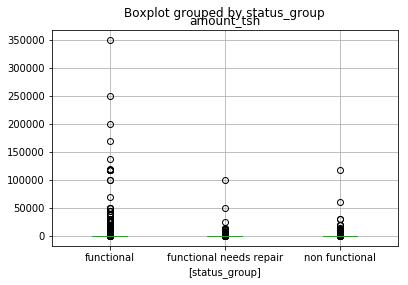

In [25]:
df_train[['amount_tsh', 'status_group']].boxplot(by = 'status_group')

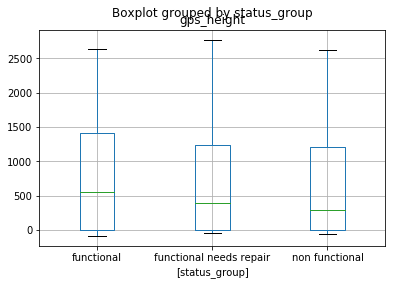

In [26]:
df_train[['gps_height', 'status_group']].boxplot(by = 'status_group')

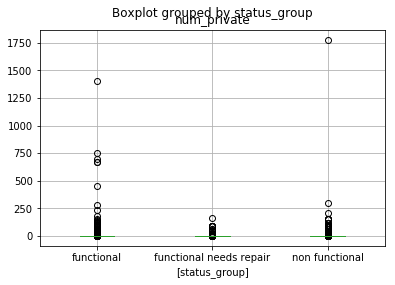

In [27]:
df_train[['num_private', 'status_group']].boxplot(by = 'status_group')

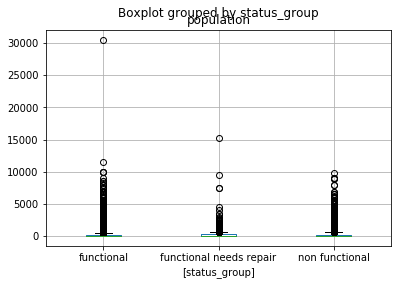

In [28]:
df_train[['population', 'status_group']].boxplot(by = 'status_group')

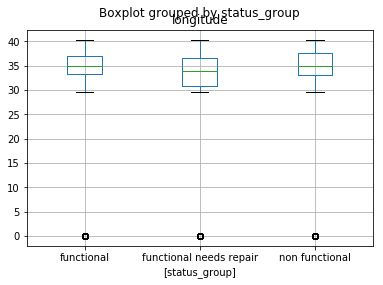

In [58]:
df_train[['longitude', 'status_group']].boxplot(by = 'status_group')

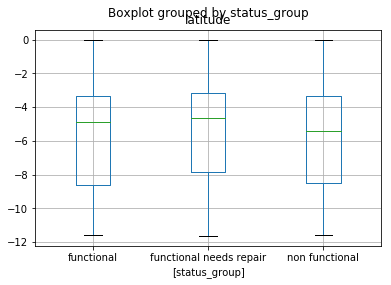

In [60]:
df_train[['latitude', 'status_group']].boxplot(by = 'status_group')

1. From the boxplots above, the continuous variables `amount_tsh`, `population` and `num_private`, are highly skewed with long tails. 
2. To make the sns pair plot visualization easier to understand, I excluded the pumps in the `functional needs repair` category and took log transformation for `amount_tsh`, `population` and `num_private` variables.

In [29]:
df_train2 = df_train.loc[df_train['status_group'] != 'functional needs repair',].copy()

In [30]:
df_train2['amount_tsh_log'] = np.log(df_train2['amount_tsh'])
df_train2['population_log'] = np.log(df_train2['population'])
df_train2['num_private_log'] = np.log(df_train2['num_private'])
# 'gps_height', 'num_private', 'population',

CPU times: user 6.26 s, sys: 56.2 ms, total: 6.32 s
Wall time: 6.39 s


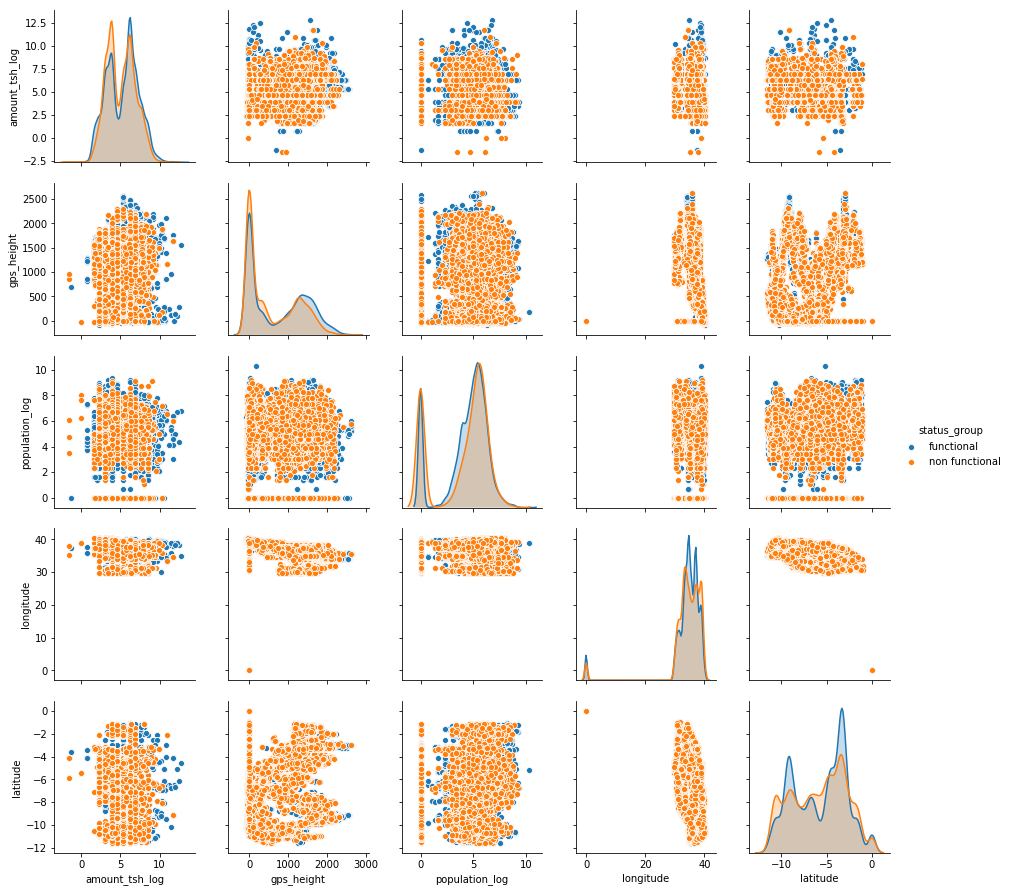

In [62]:
%%time
sns.pairplot(df_train2[['amount_tsh_log', 'gps_height', 'population_log', \
                        'longitude', 'latitude','status_group']],
             hue = 'status_group')

**Learning from continous features analysis**
1. `amount_tsh`, `num_private` and `population` varibles are highly left skewed.
2. Functional pumps have more outliers regarding the amount of water than non-functional pumps.
3. Functional pumps are more likely to have higher `gps_height`, `longtitude` and `latitude`
4. Functional pumps have slightly more population around the well than non-functional pumps.
5. There are no apparent correlations between these continous variables.

## Data Preprocessing<a class="anchor" id="data_preprocessing"></a>

[Back to TOC](#toc)

### Drop columns for dummying

In [32]:
# Drop columns with only one value
if "recorded_by" in df_train.columns.values:
    df_train.drop("recorded_by", axis=1, inplace=True)

In [33]:
df_explore_train[df_explore_train['dtypes'] == 'object'].sort_values('nunique', ascending = False).head(10)

,nunique,null%,nsingle,dtypes
wpt_name,37400,0.000000,32928,object
subvillage,19287,0.624579,9424,object
scheme_name,2696,47.417508,712,object
installer,2145,6.153199,1098,object
ward,2092,0.000000,30,object
funder,1897,6.119529,974,object
date_recorded,356,0.000000,35,object
lga,125,0.000000,1,object
region,21,0.000000,0,object
extraction_type,18,0.000000,0,object


Remove some columns since they are not meaningful for the model. Some columns have too many distinct values, which might add many columns when creating dummy variables.
1. `wpt_name`: it is the name of the well
2. `subvillage`, `ward` `lga` are all geographic location for the well, I will remove them since they have too many distinct values.
3. `date_recorded` and `installer`: I don't think `date_recorded` and `installer` have any prediction power for this problem.
4. `funder` and `scheme_name` is removed due to too many distinct values.

In [34]:
# Drop columns with too many distinct values which create too many features when dummying
if "funder" in df_train.columns.values:
    df_train.drop("funder", axis=1, inplace=True)
if "installer" in df_train.columns.values:   
    df_train.drop("installer", axis=1, inplace=True)      
if "wpt_name" in df_train.columns.values:
    df_train.drop("wpt_name", axis=1, inplace=True)
if "subvillage" in df_train.columns.values:
    df_train.drop("subvillage", axis=1, inplace=True)
if "ward" in df_train.columns.values:
    df_train.drop("ward", axis=1, inplace=True)
if "lga" in df_train.columns.values:
    df_train.drop("lga", axis=1, inplace=True)
if "date_recorded" in df_train.columns.values:
    df_train.drop("date_recorded", axis=1, inplace=True)
if "scheme_name" in df_train.columns.values:
    df_train.drop("scheme_name", axis=1, inplace=True)

### How to deal with missing values

In [35]:
df_explore_train[df_explore_train['null%'] > 0]

,nunique,null%,nsingle,dtypes
funder,1897,6.119529,974,object
installer,2145,6.153199,1098,object
subvillage,19287,0.624579,9424,object
public_meeting,2,5.612795,0,object
scheme_management,12,6.526936,1,object
scheme_name,2696,47.417508,712,object
permit,2,5.144781,0,object


All of the columns with missing data are categorical variables. There are three options when dealing with missing data in categorical variables:

1. Delete the rows with missing value
2. Fill the missing values with the majority group
3. Treat missing values as a seperate group

For the purpose of this project, I decided to use the third approach.

### Create dummy variables for categorical variables

In addition, variables `region_code` and `district_code` should be considered as categorical variables instead of integers to avoid unnecessary dependency.

In [36]:
df_train['region_code'] = df_train['region_code'].astype('str')
df_train['district_code'] = df_train['district_code'].astype('str')

In [37]:
cat_df = df_train.select_dtypes(include=['object']).copy()
#Pull a list of the column names of the categorical variables
cat_cols_lst = list(cat_df.columns)
#Remove label from the list
cat_cols_lst.remove('status_group')

def create_dummy_df(df, cat_cols, dummy_na):
    """
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
    1. contains all columns that were not specified as categorical
    2. removes all the original columns in cat_cols
    3. dummy columns for each of the categorical columns in cat_cols
    4. if dummy_na is True - it also contains dummy columns for the NaN values
    5. Use a prefix of the column name with an underscore (_) for separating 
    """
    cat_df = pd.get_dummies(df[cat_cols], prefix = cat_cols, prefix_sep='_', dummy_na = dummy_na, drop_first=True)
    df_copy = df.drop(cat_cols, axis = 1)
    df_copy = df_copy.merge(cat_df, how = 'inner', left_index = True, right_index = True)

    return df_copy

In [38]:
%%time
df_train_feature = create_dummy_df(df_train, cat_cols_lst, dummy_na=True)
df_train_feature = df_train_feature.loc[:, df_train_feature.columns != 'status_group']
df_train_label = df_train['status_group']

CPU times: user 214 ms, sys: 52.6 ms, total: 267 ms
Wall time: 265 ms


## Modelling and Evaluation - Random Forest Pipeline<a class="anchor" id="model_eval"></a>

[Back to TOC](#toc)

In [92]:
%%time
#X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_train_feature, df_train_label, test_size=0.3, random_state=42)
clf_simple = sklearn.ensemble.RandomForestClassifier()
clf_simple.fit(X_train, y_train)
y_pred_simple = clf_simple.predict(X_test)
report_simple = sklearn.metrics.classification_report(y_test, y_pred_simple)
print(report_simple)

                         precision    recall  f1-score   support

             functional       0.80      0.87      0.83      9724
functional needs repair       0.47      0.35      0.40      1293
         non functional       0.82      0.75      0.78      6803

              micro avg       0.79      0.79      0.79     17820
              macro avg       0.70      0.66      0.67     17820
           weighted avg       0.78      0.79      0.78     17820

CPU times: user 1.74 s, sys: 86.3 ms, total: 1.83 s
Wall time: 1.89 s


In [39]:
%%time
select_feature = sklearn.feature_selection.SelectKBest(k=100)
clf = sklearn.ensemble.RandomForestClassifier()

steps = [('feature_selection', select_feature),
         ('random_forest', clf)]

pipeline = sklearn.pipeline.Pipeline(steps)

parameters = dict(feature_selection__k=[100, 200], 
              random_forest__n_estimators=[100, 200],
              random_forest__min_samples_split=[2, 3, 4])

cv = sklearn.model_selection.GridSearchCV(pipeline, param_grid=parameters, verbose=False)

cv.fit(X_train, y_train)
y_predictions = cv.predict(X_test)
report = sklearn.metrics.classification_report(y_test, y_predictions)
print(report)

                         precision    recall  f1-score   support

             functional       0.81      0.87      0.84      9724
functional needs repair       0.51      0.34      0.41      1293
         non functional       0.82      0.78      0.80      6803

              micro avg       0.80      0.80      0.80     17820
              macro avg       0.72      0.67      0.68     17820
           weighted avg       0.79      0.80      0.79     17820

CPU times: user 7min 26s, sys: 12.9 s, total: 7min 39s
Wall time: 7min 33s


In [40]:
cv.best_params_ 

{'feature_selection__k': 200,
 'random_forest__min_samples_split': 4,
 'random_forest__n_estimators': 200}

In [41]:
importance = cv.best_estimator_.named_steps["random_forest"].feature_importances_

In [42]:
feature_list = list(df_train_feature.columns[cv.best_estimator_.\
                                             named_steps["feature_selection"].get_support()])

In [43]:
feature_importance = {'Feature': feature_list,
                       'Importance': importance}
df_feature_importance = pd.DataFrame(feature_importance)

In [63]:
df_feature_importance.sort_values("Importance", ascending=False).head(12)

,Feature,Importance
3,latitude,0.120937
2,longitude,0.120689
1,gps_height,0.057906
6,construction_year,0.049249
5,population,0.040828
166,quantity_enough,0.026409
170,quantity_group_enough,0.024260
0,amount_tsh,0.020922
199,waterpoint_type_group_other,0.019717
167,quantity_insufficient,0.018187


**Why choose Random Forest as classifier for this problem?**

1. The strengths of a Random Forest model are:
    1. Random forests combine the predictions of multiple decision trees. The model is robust to outliers.
    2. Able to model non-linear decision boundaries.
    3. Suitable for multi-class classification.
    4. Don't make assumptions on the input data distribution

2. The weaknesses of a Random Forest model are:

    1. Random forest is a black box model. It comprise randomly generated decision trees, and are not guided by explicitly guidelines in predictions. The result is difficult to interpret and may have ethical issues.
    2. Unlike a linear regression model, which would be able to extrapolate a trend, random forests are unable to extrapolate predictions for cases that have not been previously encountered.
    3. Need to be set well its randomization parameters. (Selection of nodes, number of trees, randomization of instance variables).

My data is a multi-class classification problem. I'd like my predictions to be as accurate as possible without many ethical concerns. I don't really need an extremely clear interpretation of the result.

The distribution of the input data is not Gaussian distribution. I need a model that doesn't assume Gaussian distribution.
Since the model performance (accuracy, precision) is what I care about, Random Forest is easy to implement and has good model performance in general.

**Parameters for the model**

I used `GridSearch` and `cross validation` method to get the best parameters for the model:
1. Select 200 best features to as input of the model
2. The number of trees in the forest is 200
3. The minimum number of samples required to split an internal node is 4

**Model Evaluation**

**Precision** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

**Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 1$, this is called the **F$_{1}$ score**.

The Random Forest model using the best parameters did a good job predicting functional and non-functional pumps. 87% recall for functional pumps and 78% recall for not functional pumps. However, the model is not good at predicting the third status, which is functional but needs repair (34% recall).

**Feature importance**

The feature importance aligns with my exploratory data analysis results:
1. The `longitude`, `latitude` and `gps_height` have an important impact on the status of the pumps
2. The population around the well, the quantity and quality of the water are also strong predictors.

## Deployment - Put everything together into reproducible code<a class="anchor" id="deployment"></a>

[Back to TOC](#toc)

It's important to make the code **usable, reusable, maintainable and reproducible** so that the work can be shared and used by other people.

I included a command line interface for the users to input the location/names of the data source. For example, users may run below code in their command line interface (`rf_model.py` is the name of the python file).

```
python rf_model.py --files http://s3.amazonaws.com/drivendata/data/7/public/4910797b-ee55-40a7-8668-10efd5c1b960.csv,http://s3.amazonaws.com/drivendata/data/7/public/0bf8bc6e-30d0-4c50-956a-603fc693d966.csv 
```

```python
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.tree
import sklearn.ensemble
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import logging
import argparse

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def read_data(feature_file, label_file):
	"""
	read in feature file and label file for the project
	-----------
	Input:
	1. feature_file: the url or file name for the feature file
	2. label_file; the url or file name for the label file
	Output:
	1. Pandas dataframe for features with id as index
	2. Pandas dataframe for label with id as index
	"""
    df_feature = pd.read_csv(feature_file)
    df_label = pd.read_csv(label_file)
    df_feature.set_index('id', inplace=True)
    df_label.set_index('id', inplace=True)
    return df_feature, df_label

def get_cols_drop():
	"""
	get a list of column names that need to drop
	"""
    cols_drop = ['recorded_by', 'scheme_name', 'funder', 'installer', \
                'wpt_name', 'subvillage', 'ward', 'lga', 'date_recorded']
    return cols_drop

def convert_int_to_str(df):
	"""
	convert integer variables region_code and district_code to categorical variables
	----------
	Input: pandas dataframe
	Ouput: pandas dataframe after converting integer variables region_code and district_code to categorical variables
	"""
    df['region_code'] = df['region_code'].astype('str')
    df['district_code'] = df['district_code'].astype('str')
    return df

def get_cols_dummy():
	"""
	return a list of categorical variables that need to be transformed into dummy variables
	"""
    cols_dummy = ['basin','region','region_code','district_code','public_meeting','scheme_management','permit',\
                  'extraction_type','extraction_type_group','extraction_type_class','management',\
                  'management_group','payment','payment_type','water_quality','quality_group','quantity',\
                  'quantity_group','source','source_type','source_class','waterpoint_type','waterpoint_type_group']
    return cols_dummy

def preprocess_feature(df):
	"""
	drop columns, convert two integer columns to string, create dummy variables for categorical columns
	----------
	Input: pandas dataframe for features
	Ouput: pandas dataframe after the transformation
	"""
    cols_drop = get_cols_drop()
    cat_cols = get_cols_dummy()
    df.drop(cols_drop, axis=1, inplace=True)
    df = convert_int_to_str(df)
    for col in cat_cols:
        cat_df = pd.get_dummies(df[col], prefix = col, prefix_sep='_', dummy_na=True,
                               drop_first=False)
        df = df.drop(col, axis=1)
        df = df.merge(cat_df, how='inner', left_index=True, right_index=True)
        logger.info("dummy col:{}".format(col))
    return df

def build_random_forest(X_train, y_train):
	"""
	Use pipeline to combine select k best features and random forest steps, fit the training data
	Input:
	1. feature variables (pandas dataframe)
	2. label variable (pandas dataframe)
	Output:
	1. a pipeline model that combines the select k best features step and the random forest step
	"""
    select_feature = sklearn.feature_selection.SelectKBest(k=100)
    clf = sklearn.ensemble.RandomForestClassifier()
    steps = [('feature_selection', select_feature),
             ('random_forest', clf)]
    pipeline = sklearn.pipeline.Pipeline(steps)
    pipeline.fit(X_train, y_train)
    return pipeline

def predict_random_forest(X_test, model):
	"""
	Predict the label variables using an existing model for a new dataset
	----------
	Input:
	1. new feature dataset
	2. a classification model
	Output:
	1. The prediction result for the new feature dataset using the input classification model
	"""
    y_predictions = model.predict(X_test)
    return y_predictions

def evaluate_random_forest(y_test, y_pred):
	"""
	evaluation the random forest model by comparing the predicted results with the true results
	----------
	Input: 
	1. predicted label variable
	2. true label variable
	Ouput:
	1. classification report that shows accuracy, precision, recall
	"""
    report = sklearn.metrics.classification_report(y_test, y_pred)
    print(report)

def main():
    parser = argparse.ArgumentParser()
    parser.add_argument('--files', type=str, help="data file url or csv file path")
    args = parser.parse_args()
    file_list = args.files.split(",")
    logger.info(file_list)
    feature_file = file_list[0]
    label_file = file_list[1]
    df_feature, df_label = read_data(feature_file, label_file)
    df_feature = preprocess_feature(df_feature)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(df_feature, \
		df_label, test_size=0.2, random_state=42)
    model = build_random_forest(X_train, y_train)
    y_pred = predict_random_forest(X_test, model)
    evaluate_random_forest(y_test, y_pred)

if __name__=="__main__":
	main()
```

## Unit Testing<a class="anchor" id="unit_test"></a>

[Back to TOC](#toc)

In [74]:
data = {'col1': ['A','A','B','B','C'],
       'col2': [1,4,5,7,5],
       'col3': ['M','M','N','N','N']}
df_test = pd.DataFrame(data)

In [75]:
df_test

,col1,col2,col3
0,A,1,M
1,A,4,M
2,B,5,N
3,B,7,N
4,C,5,N


In [67]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [77]:
def preprocess_feature(df, cols_drop, cat_cols):
    if cols_drop in df.columns.values:
        df.drop([cols_drop], axis=1, inplace=True)
    for col in cat_cols:
        cat_df = pd.get_dummies(df[col], prefix = col, prefix_sep='_', dummy_na=True,
                               drop_first=False)
        df = df.drop(col, axis=1)
        df = df.merge(cat_df, how='inner', left_index=True, right_index=True)
        logger.info("dummy col:{}".format(col))
    return df

In [78]:
df2 = preprocess_feature(df_test, 'col2', ['col1', 'col3'])

INFO:__main__:dummy col:col1
INFO:__main__:dummy col:col3


In [79]:
df2

,col1_A,col1_B,col1_C,col1_nan,col3_M,col3_N,col3_nan
0,1,0,0,0,1,0,0
1,1,0,0,0,1,0,0
2,0,1,0,0,0,1,0
3,0,1,0,0,0,1,0
4,0,0,1,0,0,1,0


In [83]:
data2 = {'col1_A': [1, 1, 0, 0, 0],
         'col1_B': [0, 0, 1, 1, 0],
         'col1_C': [0, 0, 0, 0, 1],
         'col1_nan': [0, 0, 0, 0, 0],
         'col3_M': [1, 1, 0, 0, 0],
         'col3_N': [0, 0, 1, 1, 1],
         'col3_nan': [0,0, 0, 0, 0]}
df3 = pd.DataFrame(data2)
df3 == df2

,col1_A,col1_B,col1_C,col1_nan,col3_M,col3_N,col3_nan
0,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True
